In [ ]:
pip install iterative-stratification

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

datapath = "/content/gdrive/My Drive/Datasets/MoA/"

Mounted at /content/gdrive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
import random as r

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r
import seaborn as sns
import math

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [6]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def getCol(x):
    return [col for col in x.columns]

def preprocess(x, *args):
    df = x.copy()
    df[args[0]] = df[args[0]].map({"trt_cp" : 0, "ctl_vehicle" : 1})
    df[args[1]] = df[args[1]].map({24 : 0, 48 : 1, 72 : 2})
    df[args[2]] = df[args[2]].map({"D1" : 0, "D2": 1})
    return df

def G_Scale(x=None, std_scale=5, scale=1, show_disp=True):
    mu    = x.shape[1]/2
    sigma = x.shape[1] * (2**std_scale)

    x_1 = np.subtract(x, mu)**2
    e_p = np.multiply(-0.5/sigma, x_1)

    g_f = (1/math.sqrt(math.pi * 2)) * np.exp(e_p) * scale

    x_Axis = np.arange(0, x.shape[1])
    x_   = np.subtract(x_Axis, mu)**2
    epf  = np.multiply(-0.5/sigma, x_)
    func = (1/math.sqrt(math.pi * 2)) * np.exp(epf) * scale

    if not show_disp:
        plt.figure(figsize=(8,6))
        plt.plot(x_Axis, func, "r")
        plt.xlabel("Samples --->")
        plt.ylabel("Amplitude --->")
        plt.title("Gauss Function Used")
        plt.show()
    return g_f

def log_loss_metric(y_true, y_pred, num_classes=206):
  metric = []
  for i in range(num_classes):
    metric.append(log_loss(y_true[:, i], y_pred[:, i], labels=[0, 1], eps=1e-15))
  return sum(metric)/num_classes

sc_X = StandardScaler()

NUM_CLASSES  = 206
NUM_FEATURES = 785

In [7]:
top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
              18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
              32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
              47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
              74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
              89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
              102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
              129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
              144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
              171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
              184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
              198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
              213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
              227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
              240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
              254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
              267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
              281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
              295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
              310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
              324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
              337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
              350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
              363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
              378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
              392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
              405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
              419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
              432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
              447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
              463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
              476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
              490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
              506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
              522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
              538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
              552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
              571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
              586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
              600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
              618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
              631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
              645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
              660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
              673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
              686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
              701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
              718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
              733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
              748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
              762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
              775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
              789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
              804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
              821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
              837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
              854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
              870, 871, 872, 873, 874]

In [8]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
  
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

In [9]:
class CFG():
  tr_batch_size = 128
  va_batch_size = 128
  ts_batch_size = 512

  epochs = 50

  IL = NUM_FEATURES
  HL = [2048, 1024]
  OL = NUM_CLASSES

  n_folds = 4
  n_seeds = 3

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

In [10]:
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(ANN, this).__init__()

        this.HL = HL
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)

        this.BN1 = nn.BatchNorm1d(IL)
        this.FC1 = WN(nn.Linear(IL, HL[0]))

        this.BN2 = nn.BatchNorm1d(HL[0])
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))

        this.BN3 = nn.BatchNorm1d(HL[1])
        this.FC3 = WN(nn.Linear(HL[1], OL))

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def forward(this, x):
        x = this.BN1(x)
        x = this.DP1(x)
        x = F.relu(this.FC1(x))
        x = this.BN2(x)
        x = this.DP2(x)
        x = F.relu(this.FC2(x))
        x = this.BN3(x)
        x = this.DP2(x)
        x = torch.sigmoid(this.FC3(x))
        return x

In [11]:
def train_fn(X=None, y=None, n_folds=None, n_seeds=None, HL_Used=None):
  breaker()
  print("Training ...")
  breaker()

  LP = []
  names = []
  bestLoss = {"train" : np.inf, "valid" : np.inf}

  r.seed(1729)
  seeders = [r.randint(0,99) for i in range(n_seeds)]
  start_time = time()

  for seed in seeders:
    fold = 0
    for tr_idx, va_idx in MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed).split(X, y):
      print("Processing Seed {seed}, Fold {fold} ...".format(seed=seed, fold=fold+1))

      X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

      tr_data_setup = DS(X_train, y_train)
      va_data_setup = DS(X_valid, y_valid)

      dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                     "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
                    }

      torch.manual_seed(0)
      model = ANN(cfg.IL, cfg.HL, cfg.OL)
      model.to(cfg.device)

      optimizer = model.getOptimizer(lr=1e-3, wd=1e-5)
      scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, eps=1e-8, verbose=True)

      for e in range(cfg.epochs):
        epochLoss = {"train" : 0, "valid" : 0}
        for phase in ["train", "valid"]:
          if phase == "train":
            model.train()
          else:
            model.eval()
          lossPerPass = 0

          for feats, label in dataloaders[phase]:
            feats, label = feats.to(cfg.device), label.to(cfg.device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
              output = model(feats)
              loss   = nn.BCELoss()(output, label)
              if phase == "train":
                loss.backward()
                optimizer.step()
            lossPerPass = (loss.item()/label.shape[0])
          epochLoss[phase] = lossPerPass
        LP.append(epochLoss)
        scheduler.step(epochLoss["valid"])
        name = "./Model_Fold_{fold}_Seed_{seed}.pt".format(fold=fold, seed=seed)
        names.append(name)
        torch.save(model.state_dict(), name)
        if epochLoss["valid"] < bestLoss["valid"]:
          bestLoss = epochLoss
          #name = "Model_Fold_{fold}_Seed_{seed}.pt".format(fold=fold, seed=seed)
          #names.append(name)
          #torch.save(model.state_dict(), datapath+name)
      fold += 1

  breaker()
  print("Time Taken to Train {n} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, n=n_folds, e=cfg.epochs))
  breaker()
  print("Best Loss (Train) : {}".format(bestLoss["train"] * cfg.tr_batch_size))
  print("Best Loss (Valid) : {}".format(bestLoss["valid"] * cfg.va_batch_size))
  breaker()
  print("Training Completed")
  breaker()
    
  return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs_test=None):
  y_pred = np.zeros((num_obs_test, NUM_CLASSES))

  for name in names:
    Pred = torch.zeros(cfg.ts_batch_size, NUM_CLASSES).to(cfg.device)
    model.load_state_dict(torch.load(name))
    model.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred = np.add(y_pred, Pred)
  y_pred = np.divide(y_pred, len(names))
  return y_pred

# Gaussian Scaling

```STD_SCALE = 5, SCALE: 1```

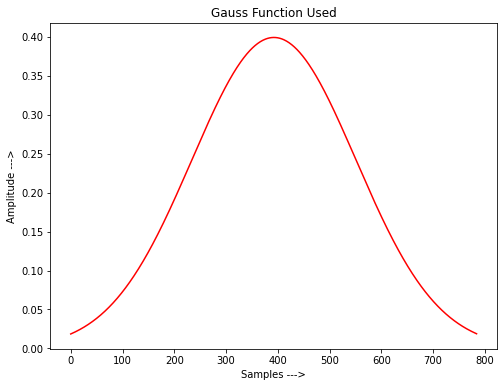


------------------------------

Training ...

------------------------------

Processing Seed 83, Fold 1 ...
Epoch    34: reducing learning rate of group 0 to 1.0000e-04.
Epoch    39: reducing learning rate of group 0 to 1.0000e-05.
Epoch    44: reducing learning rate of group 0 to 1.0000e-06.
Epoch    49: reducing learning rate of group 0 to 1.0000e-07.
Processing Seed 83, Fold 2 ...
Epoch    33: reducing learning rate of group 0 to 1.0000e-04.
Processing Seed 83, Fold 3 ...
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Epoch    31: reducing learning rate of group 0 to 1.0000e-06.
Epoch    36: reducing learning rate of group 0 to 1.0000e-07.
Epoch    41: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 4 ...
Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Epoch    43: reducing learning rate of group 0 to 1.0

In [ ]:
tr_feat = pd.read_csv(datapath + "train.csv")
tr_lbls = pd.read_csv(datapath + "train_targets_s.csv")

tr_lbls = tr_lbls.drop(labels="sig_id", axis=1)

tr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")

tr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)
tr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)

features = tr_feat.copy().values
labels   = tr_lbls.copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=6948, shuffle=True, random_state=0)

X, X_test, y, y_test = X[:, top_feats].astype(float), X_test[:, top_feats].astype(float), y.astype(float), y_test.astype(float)

# --------------------------------- #
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)
# --------------------------------- #

X = G_Scale(X)
X_test = G_Scale(X_test, show_disp=False)

del tr_feat, tr_lbls, features, labels

########## TRAINING ###########
LP_1, names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, n_seeds=cfg.n_seeds)

########## EVALUATION #########
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, set(names), ts_data, ts_data_setup.__len__())

print(log_loss_metric(y_test, y_pred))
breaker()

```STD_SCALE = 5, SCALE: 5```


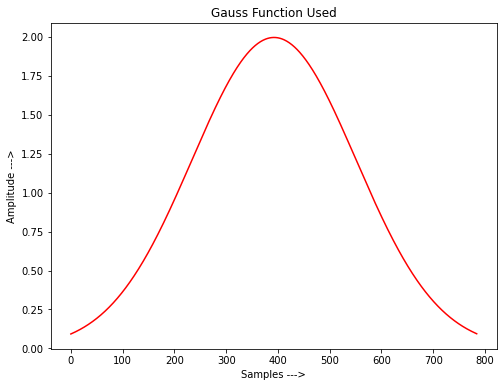


------------------------------

Training ...

------------------------------

Processing Seed 83, Fold 1 ...
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
Epoch    33: reducing learning rate of group 0 to 1.0000e-06.
Epoch    38: reducing learning rate of group 0 to 1.0000e-07.
Epoch    43: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 2 ...
Epoch    33: reducing learning rate of group 0 to 1.0000e-04.
Epoch    45: reducing learning rate of group 0 to 1.0000e-05.
Processing Seed 83, Fold 3 ...
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch    31: reducing learning rate of group 0 to 1.0000e-05.
Epoch    36: reducing learning rate of group 0 to 1.0000e-06.
Epoch    41: reducing learning rate of group 0 to 1.0000e-07.
Epoch    46: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 4 ...
Epoch    29: reducing learning rate of group 0 to 1.0

In [ ]:
tr_feat = pd.read_csv(datapath + "train.csv")
tr_lbls = pd.read_csv(datapath + "train_targets_s.csv")

tr_lbls = tr_lbls.drop(labels="sig_id", axis=1)

tr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")

tr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)
tr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)

features = tr_feat.copy().values
labels   = tr_lbls.copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=6948, shuffle=True, random_state=0)

X, X_test, y, y_test = X[:, top_feats].astype(float), X_test[:, top_feats].astype(float), y.astype(float), y_test.astype(float)

# --------------------------------- #
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)
# --------------------------------- #

X = G_Scale(X, scale=5)
X_test = G_Scale(X_test, scale=5, show_disp=False)

del tr_feat, tr_lbls, features, labels

########## TRAINING ###########
LP, names, Network = train_fn(X=X, y=y, n_folds=cfg.n_folds, n_seeds=cfg.n_seeds)

########## EVALUATION #########
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, set(names), ts_data, ts_data_setup.__len__())

print(log_loss_metric(y_test, y_pred))
breaker()

```STD_SCALE = 5, SCALE: 2.5```


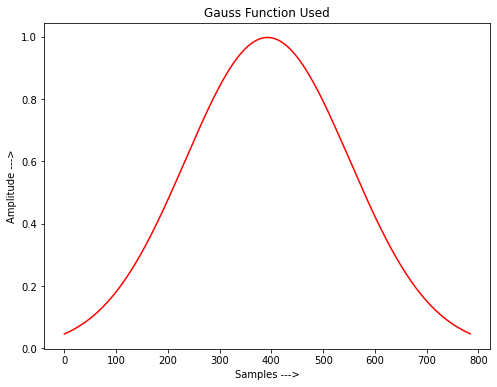


------------------------------

Training ...

------------------------------

Processing Seed 83, Fold 1 ...
Epoch    27: reducing learning rate of group 0 to 1.0000e-04.
Epoch    33: reducing learning rate of group 0 to 1.0000e-05.
Epoch    38: reducing learning rate of group 0 to 1.0000e-06.
Epoch    43: reducing learning rate of group 0 to 1.0000e-07.
Epoch    48: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 2 ...
Epoch    32: reducing learning rate of group 0 to 1.0000e-04.
Processing Seed 83, Fold 3 ...
Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch    34: reducing learning rate of group 0 to 1.0000e-06.
Epoch    39: reducing learning rate of group 0 to 1.0000e-07.
Epoch    44: reducing learning rate of group 0 to 1.0000e-08.
Processing Seed 83, Fold 4 ...
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
Processing Seed 5, Fold 1 ...
Epoch    24: reducing l

In [ ]:
tr_feat = pd.read_csv(datapath + "train.csv")
tr_lbls = pd.read_csv(datapath + "train_targets_s.csv")

tr_lbls = tr_lbls.drop(labels="sig_id", axis=1)

tr_feat = preprocess(tr_feat, "cp_type", "cp_time", "cp_dose")

tr_lbls = tr_lbls.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)
tr_feat = tr_feat.loc[tr_feat["cp_type"] == 0].reset_index(drop=True)

features = tr_feat.copy().values
labels   = tr_lbls.copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=6948, shuffle=True, random_state=0)

X, X_test, y, y_test = X[:, top_feats].astype(float), X_test[:, top_feats].astype(float), y.astype(float), y_test.astype(float)

# --------------------------------- #
X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)
# --------------------------------- #

X = G_Scale(X, scale=2.5)
X_test = G_Scale(X_test, scale=2.5, show_disp=False)

del tr_feat, tr_lbls, features, labels

########## TRAINING ###########
LP, names, Network = train_fn(X=X, y=y, n_folds=cfg.n_folds, n_seeds=cfg.n_seeds)

########## EVALUATION #########
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, set(names), ts_data, ts_data_setup.__len__())

print(log_loss_metric(y_test, y_pred))
breaker()